# NGCF: a baseline implementation

## 1. Imports

In [1]:
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from numpy import diag
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.optim import Adam
from torch.nn import MSELoss
from os import path
import io

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_test.csv to data_test.csv
Saving data_train.csv to data_train.csv


## 2. Utils

### 2.1. Data loader

In [3]:
# load 100k data

def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

def load100KRatings():
    data_pd = pd.read_csv(io.BytesIO(uploaded['data_train.csv']))
    print("BEFORE: ", data_pd.shape)
    users, movies, ratings = extract_users_items_predictions(data_pd)
    df = pd.DataFrame({'userId': users, 'itemId': movies, 'rating': ratings})
    #df = pd.read_table(path100k+r'\u.data',sep='\t',names=['userId','itemId','rating','timestamp'])
    return df


# movielens 1k
class ML1K(Dataset):

    def __init__(self,rt):
        super(Dataset,self).__init__()
        self.uId = list(rt['userId'])
        self.iId = list(rt['itemId'])
        self.rt = list(rt['rating'])

    def __len__(self):
        return len(self.uId)

    def __getitem__(self, item):
        return (self.uId[item],self.iId[item],self.rt[item])



### 2.2. Dimensionality Reduction

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### 2.3. User-user and Item-item similarity

In [5]:
from scipy.sparse import linalg
from scipy.stats import pearsonr

def normalization(dataframe):
    dataframe_mean = dataframe.mean(axis=1)
    #dataframe_std = dataframe.std(axis=1)
    return dataframe.subtract(dataframe_mean, axis = 'rows')#.divide(dataframe_std, axis = 'rows')

def ii_similarity(ds):
  tmp = ds.pivot_table(values="rating",index="userId",columns="itemId")
  new = tmp.fillna(tmp.mean())
  #return new.transpose().dot(new)
  return new.corr()

def uu_similarity(ds):
  tmp = ds.pivot_table(values="rating",index="userId",columns="itemId")
  new = tmp.fillna(tmp.mean())
  #return new.dot(new.transpose())
  return new.T.corr()



## 4. Main

In [6]:
rt = load100KRatings()
userNum = rt['userId'].max() + 1
itemNum = rt['itemId'].max() + 1

rt['userId'] = rt['userId']
rt['itemId'] = rt['itemId']

rt

BEFORE:  (1176952, 2)


,userId,itemId,rating
0,43,0,4
1,60,0,3
2,66,0,4
3,71,0,3
4,85,0,5
...,...,...,...
1176947,9989,999,4
1176948,9991,999,5
1176949,9993,999,3
1176950,9996,999,4


Dimensionality

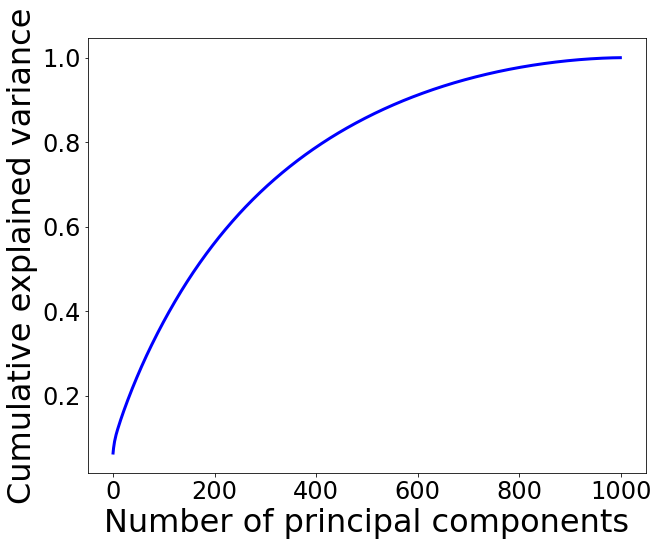

In [12]:
plt.rc('axes', titlesize=25)  # fontsize of the axes title
plt.rc('axes', labelsize=32)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=24)  # fontsize of the tick labels
plt.rc('ytick', labelsize=24)  # fontsize of the tick labels
plt.rc('legend', fontsize=50)  # legend fontsize

subplots = (1, 1)
fig, ax = plt.subplots(subplots[0], subplots[0], figsize=(10, 8))

# Change dataset structure
movie_ratings_nan = rt.pivot_table(values="rating",index="userId",columns="itemId")
movie_ratings = movie_ratings_nan.fillna(0)#(movie_ratings_nan.mean())
# Perform PCA
pca = PCA().fit(movie_ratings)

ax.plot(np.cumsum(pca.explained_variance_ratio_),
                #marker="|",
                markersize=9,
                linewidth=3,
                mew=3,
                #markeredgecolor="black",
                fillstyle="none",
                color="blue")

ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative explained variance')
fig.savefig("./pca.png")